# TF2 Object Detection on Amazon SageMaker - Data preparation

## Setup environment

In [1]:
# Make sure these libraries are available within your python environement.
# Uncomment the following lines to install the libraries
!pip install -q --upgrade pip
!pip install -q sagemaker==2.16.2
!pip install -q jsonlines

# Get dataset_util file from TF2 Object Detection GitHub repository
!wget -P ./docker/code/utils https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/dataset_util.py

--2021-03-01 23:49:24--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/dataset_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2837 (2.8K) [text/plain]
Saving to: ‘./docker/code/utils/dataset_util.py’

dataset_util.py     100%[===================>]   2.77K  --.-KB/s    in 0s      

2021-03-01 23:49:24 (59.9 MB/s) - ‘./docker/code/utils/dataset_util.py’ saved [2837/2837]



## Import libraries

In [2]:
import os
import boto3
import jsonlines
import sagemaker
import numpy as np
from PIL import Image
from itertools import cycle, islice
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput

sagemaker_session = sagemaker.Session()

# we are using the notebook instance role for training in this example
role = sagemaker.get_execution_role() 

# you can specify a bucket name here, we're using the default bucket of SageMaker
bucket = sagemaker_session.default_bucket() 

In [3]:
role

'arn:aws:iam::198387115458:role/service-role/AmazonSageMaker-ExecutionRole-20200508T132235'

In [4]:
bucket

'sagemaker-us-east-1-198387115458'

<a name="introduction"></a>
## Get data
In this workshop we will use a dataset from the [inaturalist.org](inaturalist.org) This dataset contains 500 images of bees that have been uploaded by inaturalist users for the purposes of recording the observation and identification. We only used images that their users have licensed under [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/) license. For your convenience, we have placed the dataset in S3 in a single zip archive here: https://tf2-object-detection.s3-eu-west-1.amazonaws.com/data/bees/dataset.zip

First, download and unzip the archive.

In [5]:
!wget -O /tmp/dataset.zip https://tf2-object-detection.s3-eu-west-1.amazonaws.com/data/bees/input/dataset.zip
!mkdir data
!unzip -qo /tmp/dataset.zip -d data

--2021-03-01 23:50:41--  https://tf2-object-detection.s3-eu-west-1.amazonaws.com/data/bees/input/dataset.zip
Resolving tf2-object-detection.s3-eu-west-1.amazonaws.com (tf2-object-detection.s3-eu-west-1.amazonaws.com)... 52.218.24.208
Connecting to tf2-object-detection.s3-eu-west-1.amazonaws.com (tf2-object-detection.s3-eu-west-1.amazonaws.com)|52.218.24.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69231892 (66M) [application/zip]
Saving to: ‘/tmp/dataset.zip’

/tmp/dataset.zip    100%[===================>]  66.02M  20.1MB/s    in 3.3s    

2021-03-01 23:50:45 (20.1 MB/s) - ‘/tmp/dataset.zip’ saved [69231892/69231892]



The archive contains the following structure: 
- 500 `.jpg` image files 
- A "output.manifest" file  (to be explained later) 

Now let's upload this dataset to your own S3 bucket in preparation for labeling and training using Amazon SageMaker.

In [6]:
prefix = 'data/bees/raw'
s3_input = sagemaker_session.upload_data('data', bucket, prefix)
print(s3_input)

s3://sagemaker-us-east-1-198387115458/data/bees/raw


## Visualize labelled images

Now let's plot all the annotated images. First, let's define a function that displays the local image file and draws over it the bounding boxes obtained via labeling.

In [7]:
def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['w', 'g', 'b', 'y', 'c', 'm', 'k', 'r'])
    
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=2,edgecolor=next(colors),facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Next, read the augmented manifest (JSON lines format) line by line and display the first 10 images.

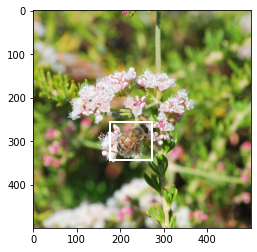

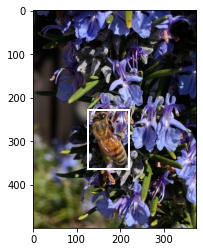

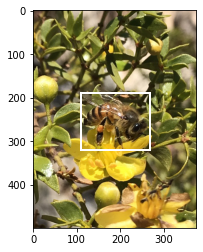

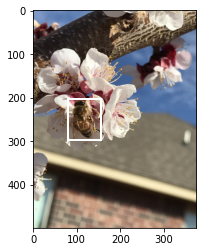

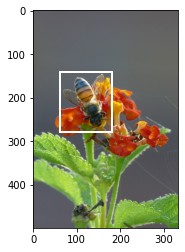

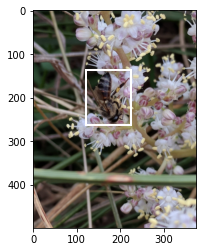

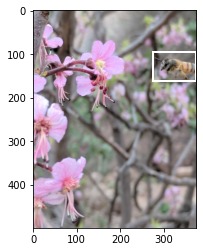

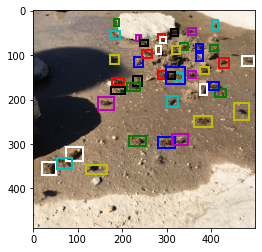

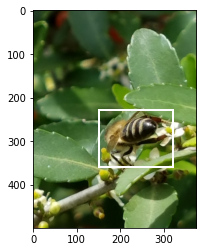

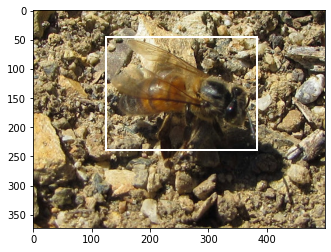

In [8]:
labeling_job_name = 'bees-500'
augmented_manifest_file = 'data/output.manifest'

with jsonlines.open(augmented_manifest_file, 'r') as reader:
    for desc in islice(reader, 10):
        img_url = desc['source-ref']
        img_file = f'data/{os.path.basename(img_url)}'
        bboxes = desc[labeling_job_name]['annotations']
        show_annotated_image(img_file, bboxes)

We will then process the object detection labels output from Ground Truth (i.e: The output manifest file) and generate TFrecords files to be used during the model training

## Build and push data processing container

As we're following the bring your own paradigm of SageMaker, the first step is to build a docker container (enabling you to chose the base docker image and libraries to be installed) and push the docker to Amazon ECR so it's accessible by Amazon SageMaker 

In [9]:
image_name = 'tfrecord-processing'

In [10]:
#The following command takes a few minutes to complete
!sh ./docker/build_and_push.sh $image_name

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Building image with name tfrecord-processing
Sending build context to Docker daemon   16.9kB
Step 1/7 : FROM tensorflow/tensorflow:2.2.0-gpu
2.2.0-gpu: Pulling from tensorflow/tensorflow

c47eeb70: Pulling fs layer 
dc448b72: Pulling fs layer 
70e39044: Pulling fs layer 
37916d57: Pulling fs layer 
569ddae6: Pulling fs layer 
6706b020: Pulling fs layer 
457b77d0: Pulling fs layer 
dd394d58: Pulling fs layer 
75142b4d: Pulling fs layer 
1fbb4940: Pulling fs layer 
8ae01855: Pulling fs layer 
4d8326b1: Pulling fs layer 
7fcee106: Pulling fs layer 
69ddae6: Waiting fs layer 
d42b7d3e: Pulling fs layer 
Digest: sha256:3f8f06cdfbc09c54568f191bbc54419b348ecc08dc5e031a53c22c6bba0a252

The following NEW packages will be installed:
  blt fontconfig-config fonts-dejavu-core git git-man less libbsd0 libcairo2
  libcurl3-gnutls libedit2 liberror-perl libfontconfig1 libgdk-pixbuf2.0-0
  libgdk-pixbuf2.0-bin libgdk-pixbuf2.0-common libicu60 libjbig0 liblcms2-2
  libpixman-1-0 libprotobuf10 libprotoc10 libssl1.0.0 libtcl8.6 libtiff5
  libtk8.6 libwebp6 libwebpdemux2 libwebpmux3 libx11-6 libx11-data libxau6
  libxcb-render0 libxcb-shm0 libxcb1 libxdmcp6 libxext6 libxft2 libxml2
  libxmuu1 libxrender1 libxslt1.1 libxss1 openssh-client protobuf-compiler
  python3-bs4 python3-cairocffi python3-cffi python3-chardet python3-html5lib
  python3-lxml python3-olefile python3-pil python3-ply python3-pycparser
  python3-tk python3-webencodings python3-xcffib shared-mime-info tk8.6-blt2.5
  tzdata ucf wget x11-common xauth
The following packages will be upgraded:
  dirmngr gnupg gnupg-l10n gnupg-utils gpg gpg-agent gpg-wks-client
  gpg-wks-server gpgconf gpgsm gpgv
11 upgraded, 64 newly

Get:71 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-olefile all 0.45.1-1 [33.3 kB]
Get:72 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 python3-pil amd64 5.1.0-1ubuntu0.4 [329 kB]
Get:73 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 python3-tk amd64 3.6.9-1~18.04 [119 kB]
Get:74 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-xcffib amd64 0.5.1-1build3 [61.6 kB]
Get:75 http://archive.ubuntu.com/ubuntu bionic/universe amd64 protobuf-compiler amd64 3.0.0-9.1ubuntu1 [24.5 kB]
debconf: delaying package configuration, since apt-utils is not installed
Fetched 28.1 MB in 3s (10.5 MB/s)
Selecting previously unselected package libxau6:amd64.
(Reading database ... 16096 files and directories currently installed.)
Preparing to unpack .../00-libxau6_1%3a1.0.8-1ubuntu1_amd64.deb ...
Unpacking libxau6:amd64 (1:1.0.8-1ubuntu1) ...
Selecting previously unselected package libbsd0:amd64.
Preparing to unpack .../01-libbsd0_0.8.7-1ubuntu0.1_amd64.deb 

Selecting previously unselected package libxcb-shm0:amd64.
Preparing to unpack .../21-libxcb-shm0_1.13-2~ubuntu18.04_amd64.deb ...
Unpacking libxcb-shm0:amd64 (1.13-2~ubuntu18.04) ...
Selecting previously unselected package libcairo2:amd64.
Preparing to unpack .../22-libcairo2_1.15.10-2ubuntu0.1_amd64.deb ...
Unpacking libcairo2:amd64 (1.15.10-2ubuntu0.1) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../23-libjbig0_2.1-3.1build1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1build1) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../24-libtiff5_4.0.9-5ubuntu0.4_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.9-5ubuntu0.4) ...
Selecting previously unselected package libgdk-pixbuf2.0-common.
Preparing to unpack .../25-libgdk-pixbuf2.0-common_2.36.11-2_all.deb ...
Unpacking libgdk-pixbuf2.0-common (2.36.11-2) ...
Selecting previously unselected package libgdk-pixbuf2.0-0:amd64.
Preparing to unpack .../26-libgdk-pixbuf2.0-0_2.

Setting up libgdk-pixbuf2.0-bin (2.36.11-2) ...
Setting up xauth (1:1.0.10-1) ...
Setting up libcairo2:amd64 (1.15.10-2ubuntu0.1) ...
Setting up libtk8.6:amd64 (8.6.8-4) ...
Setting up tk8.6-blt2.5 (2.5.3+dfsg-4) ...
Setting up python3-cairocffi (0.8.0-0ubuntu2) ...
Setting up blt (2.5.3+dfsg-4) ...
Setting up python3-tk:amd64 (3.6.9-1~18.04) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Removing intermediate container 6fb3795c763e
 ---> a300a71941cc
Step 4/7 : COPY requirements.txt /tmp/
 ---> 920030919085
Step 5/7 : RUN pip3 install -r /tmp/requirements.txt --no-cache --upgrade
 ---> Running in f80851d2a470
  Attempting uninstall: pillow
    Found existing installation: Pillow 5.1.0
    Uninstalling Pillow-5.1.0:
      Successfully uninstalled Pillow-5.1.0
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Removing intermediate container f80851d2a470
 ---> 893cc25f2b0d
Step 6

768f66a4: Pushing  1.205GB/1.616GBPushing  54.33MB/1.757GB

768f66a4: Pushed   1.623GB/1.616GBPushing  1.656GB/1.757GBlatest: digest: sha256:21fd2591bf26e63c2923bdff9c0373217e986d586294c1e3a7cf1fa3035b728b size: 4513


In [11]:
# Get the ECR image uri
with open (os.path.join('docker', 'ecr_image_fullname.txt'), 'r') as f:
    container = f.readlines()[0][:-1]
    
print(container)

198387115458.dkr.ecr.us-east-1.amazonaws.com/tfrecord-processing:latest


## Launch SageMaker processing job to generate TFrecords

In [12]:
data_processor = Processor(role=role, 
                           image_uri=container, 
                           instance_count=1, 
                           instance_type='ml.m5.xlarge',
                           volume_size_in_gb=30, 
                           max_runtime_in_seconds=1200,
                           base_job_name='tf2-object-detection')

In [ ]:
input_folder = '/opt/ml/processing/input'
ground_truth_manifest = '/opt/ml/processing/input/output.manifest'
label_map = '{"0": "bee"}' # class mapping here - e.g. - each class ID should map to the human readable equivalent
output_folder = '/opt/ml/processing/output'

data_processor.run(
    arguments= [
        f'--input={input_folder}',
        f'--ground_truth_manifest={ground_truth_manifest}',
        f'--label_map={label_map}',
        f'--output={output_folder}'
    ],
    inputs = [
        ProcessingInput(
            input_name='input',
            source=s3_input,
            destination=input_folder
        )
    ],
    outputs= [
        ProcessingOutput(
            output_name='tfrecords',
            source=output_folder,
            destination=f's3://{bucket}/data/bees/tfrecords'
        )
    ]
)


Job Name:  tf2-object-detection-2021-03-02-00-06-00-374
Inputs:  [{'InputName': 'input', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-198387115458/data/bees/raw', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'tfrecords', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-198387115458/data/bees/tfrecords', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
........................